## Import libraries

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model

## Pandas for data loading

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df = pd.read_csv('/content/dialogs.txt' , sep='\t' , names=['Question' , 'Answer'])

df.head()

,Question,Answer
0,"hi, how are you doing?",i'm fine. how about yourself?
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.
2,i'm pretty good. thanks for asking.,no problem. so how have you been?
3,no problem. so how have you been?,i've been great. what about you?
4,i've been great. what about you?,i've been good. i'm in school right now.


## Check null values

In [ ]:
# Check for null values
null_question = df['Question'].isnull().sum()
null_answer = df['Answer'].isnull().sum()

if null_question > 0:
    print("There are", null_question, "null values in the 'Question' column.")
else:
    print("There are no null values in the 'Question' column.")

if null_answer > 0:
    print("There are", null_answer, "null values in the 'Answer' column.")
else:
    print("There are no null values in the 'Answer' column.")

# Check for whitespace values
whitespace_question = df['Question'].apply(lambda x: x.isspace()).sum()
whitespace_answer = df['Answer'].apply(lambda x: x.isspace()).sum()

if whitespace_question > 0:
    print("There are", whitespace_question, "whitespace values in the 'Question' column.")
else:
    print("There are no whitespace values in the 'Question' column.")

if whitespace_answer > 0:
    print("There are", whitespace_answer, "whitespace values in the 'Answer' column.")
else:
    print("There are no whitespace values in the 'Answer' column.")

There are no null values in the 'Question' column.
There are no null values in the 'Answer' column.
There are no whitespace values in the 'Question' column.
There are no whitespace values in the 'Answer' column.


## Clean the data and tockenize

In [ ]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.lower()
    text = re.sub(r'\d+', ' ', text)  # Replace all digits with spaces
    text = re.sub(r'([^\w\s])', r' \1 ', text)  # Add a space before and after each punctuation character
    text = re.sub(r'\s+', ' ', text)  # Replace all consecutive spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces
    return text

df['Encoder Inputs']=df['Question'].apply(clean_text)
df['Decoder Inputs']="<sos> " + df['Answer'].apply(clean_text) + ' <eos>'
df["Decoder Targets"] = df['Answer'].apply(clean_text) + ' <eos>'

df.head()

,Question,Answer,Encoder Inputs,Decoder Inputs,Decoder Targets
0,"hi, how are you doing?",i'm fine. how about yourself?,hi how are you doing,<sos> i am fine how about yourself <eos>,i am fine how about yourself <eos>
1,i'm fine. how about yourself?,i'm pretty good. thanks for asking.,i am fine how about yourself,<sos> i am pretty good thanks for asking <eos>,i am pretty good thanks for asking <eos>
2,i'm pretty good. thanks for asking.,no problem. so how have you been?,i am pretty good thanks for asking,<sos> no problem so how have you been <eos>,no problem so how have you been <eos>
3,no problem. so how have you been?,i've been great. what about you?,no problem so how have you been,<sos> i have been great what about you <eos>,i have been great what about you <eos>
4,i've been great. what about you?,i've been good. i'm in school right now.,i have been great what about you,<sos> i have been good i am in school right no...,i have been good i am in school right now <eos>


In [ ]:
import pandas as pd
from keras.preprocessing.text import Tokenizer

# Load your prepared dataset
data_path = 'train_data.csv'
data = pd.read_csv(data_path)

# Initialize tokenizer
tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(data['Question'].tolist() + data['Answer'].tolist())

vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the <pad> token
print("Vocabulary Size:", vocab_size)


Vocabulary Size: 4039


# build stratch transformer model

In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, Dense, Dropout, LayerNormalization
from keras.layers import MultiHeadAttention, TimeDistributed, Concatenate
from keras.optimizers import Adam
import matplotlib.pyplot as plt


# Load data
data = pd.read_csv('train_data.csv')


special_tokens = ['<sos>', '<eos>']

# Extract encoder inputs, decoder inputs, and decoder targets from the data
encoder_inputs = data['Encoder Inputs'].tolist()
decoder_inputs = data['Decoder Inputs'].tolist()
decoder_targets = data['Decoder Targets'].tolist()

# Combine encoder inputs, decoder inputs, decoder targets, and special tokens into one list
all_texts = special_tokens + encoder_inputs + decoder_inputs + decoder_targets


# Tokenize text data
tokenizer = Tokenizer(oov_token='<unk>', filters='', lower=False)  # Set filters to empty string to preserve special tokens
tokenizer.fit_on_texts(data['Encoder Inputs'].tolist() + data['Decoder Inputs'].tolist() + data['Decoder Targets'].tolist())
vocab_size = len(tokenizer.word_index) + 1

# Check if '<sos>' is in tokenizer word index
if '<sos>' not in tokenizer.word_index:
    raise ValueError("'<sos>' token not found in tokenizer's word index. Check tokenization process.")

# Convert text sequences to integer sequences
encoder_input_data = tokenizer.texts_to_sequences(encoder_inputs)
decoder_input_data = tokenizer.texts_to_sequences(decoder_inputs)
decoder_target_data = tokenizer.texts_to_sequences(decoder_targets)

# Pad sequences
max_seq_length = max(
    max(len(seq) for seq in encoder_input_data),
    max(len(seq) for seq in decoder_input_data),
    max(len(seq) for seq in decoder_target_data)
)

encoder_input_data = pad_sequences(encoder_input_data, maxlen=max_seq_length, padding='post')
decoder_input_data = pad_sequences(decoder_input_data, maxlen=max_seq_length, padding='post')
decoder_target_data = pad_sequences(decoder_target_data, maxlen=max_seq_length, padding='post')



# Split data into training and validation sets
X_train_enc, X_val_enc, X_train_dec, X_val_dec, y_train_dec, y_val_dec = train_test_split(
    encoder_input_data, decoder_input_data, decoder_target_data, test_size=0.2, random_state=42
)

# Define Transformer model architecture
def transformer_model(vocab_size, max_seq_length, d_model=128, num_heads=4, num_encoder_layers=2, num_decoder_layers=2, dff=512, dropout_rate=0.1):
    # Encoder
    encoder_inputs = Input(shape=(max_seq_length,))
    encoder_embedding = Embedding(vocab_size, d_model)(encoder_inputs)
    encoder_dropout = Dropout(dropout_rate)(encoder_embedding)

    encoder_outputs = encoder_dropout
    for i in range(num_encoder_layers):
        encoder_outputs = transformer_encoder_layer(encoder_outputs, d_model, num_heads, dff, dropout_rate)

    # Decoder
    decoder_inputs = Input(shape=(max_seq_length,))
    decoder_embedding = Embedding(vocab_size, d_model)(decoder_inputs)
    decoder_dropout = Dropout(dropout_rate)(decoder_embedding)

    decoder_outputs = decoder_dropout
    for i in range(num_decoder_layers):
        decoder_outputs = transformer_decoder_layer(decoder_outputs, encoder_outputs, d_model, num_heads, dff, dropout_rate)

    decoder_outputs = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_outputs)

    return Model([encoder_inputs, decoder_inputs], decoder_outputs)

def transformer_encoder_layer(encoder_inputs, d_model, num_heads, dff, dropout_rate):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(encoder_inputs, encoder_inputs)
    attn_output = Dropout(dropout_rate)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(encoder_inputs + attn_output)

    ffn_output = TimeDistributed(Dense(dff, activation='relu'))(out1)
    ffn_output = TimeDistributed(Dense(d_model))(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

    return out2

def transformer_decoder_layer(decoder_inputs, encoder_outputs, d_model, num_heads, dff, dropout_rate):
    attn1 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(decoder_inputs, decoder_inputs)
    attn1 = Dropout(dropout_rate)(attn1)
    out1 = LayerNormalization(epsilon=1e-6)(decoder_inputs + attn1)

    attn2 = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(out1, encoder_outputs)
    attn2 = Dropout(dropout_rate)(attn2)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + attn2)

    ffn_output = TimeDistributed(Dense(dff, activation='relu'))(out2)
    ffn_output = TimeDistributed(Dense(d_model))(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out3 = LayerNormalization(epsilon=1e-6)(out2 + ffn_output)

    return out3



# Build Transformer

Epoch 1/20
47/47 [==============================] - 56s 765ms/step - loss: 3.2581 - accuracy: 0.6428 - val_loss: 2.0142 - val_accuracy: 0.6901
Epoch 2/20
47/47 [==============================] - 35s 755ms/step - loss: 1.8423 - accuracy: 0.7086 - val_loss: 1.7223 - val_accuracy: 0.7215
Epoch 3/20
47/47 [==============================] - 42s 893ms/step - loss: 1.5722 - accuracy: 0.7412 - val_loss: 1.5553 - val_accuracy: 0.7499
Epoch 4/20
47/47 [==============================] - 36s 779ms/step - loss: 1.3671 - accuracy: 0.7700 - val_loss: 1.4322 - val_accuracy: 0.7710
Epoch 5/20
47/47 [==============================] - 36s 778ms/step - loss: 1.1900 - accuracy: 0.7951 - val_loss: 1.3244 - val_accuracy: 0.7866
Epoch 6/20
47/47 [==============================] - 36s 767ms/step - loss: 1.0314 - accuracy: 0.8194 - val_loss: 1.2518 - val_accuracy: 0.8000
Epoch 7/20
47/47 [==============================] - 39s 839ms/step - loss: 0.8975 - accuracy: 0.8384 - val_loss: 1.1856 - val_accuracy: 0.8118

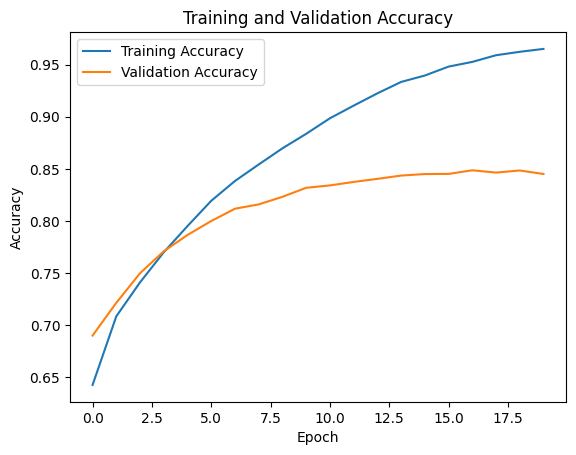

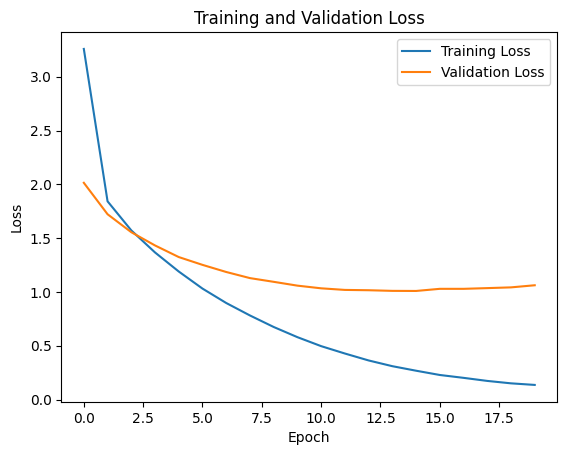

In [38]:
# Create Transformer model
model = transformer_model(vocab_size, max_seq_length)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_train_enc, X_train_dec], y_train_dec, validation_data=([X_val_enc, X_val_dec], y_val_dec), epochs=20, batch_size=64)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Define variable values
max_seq_length = 20  # Example maximum sequence length

In [69]:
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import re

# Define variable values
vocab_size = 3000  # Example vocabulary size
embedding_dim = 128  # Example embedding dimension
hidden_dim = 256  # Example hidden dimension
max_seq_length = 10  # Example maximum sequence length

# Define encoder model
encoder_inputs = Input(shape=(max_seq_length,))
encoder_embedding = Embedding(vocab_size, embedding_dim)(encoder_inputs)
encoder_outputs, state_h_enc, state_c_enc = LSTM(hidden_dim, return_state=True)(encoder_embedding)
encoder_states = [state_h_enc, state_c_enc]
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h_enc, state_c_enc])

# Define decoder model
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embedding = Embedding(vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + encoder_states, [decoder_outputs, state_h_dec, state_c_dec])




In [71]:
# Example usage
input_text = "Are you going to the movies?"
seq = tokenizer.texts_to_sequences([input_text.lower()])
input_seq = pad_sequences(seq, maxlen=max_seq_length, padding='post')
enc_output, enc_state_h, enc_state_c = encoder_model.predict(input_seq)
dec_input = np.zeros((1, 1))
dec_input[0, 0] = tokenizer.word_index['<sos>']
dec_states = [enc_state_h, enc_state_c]
output_tokens = []

while True:
    dec_output, dec_state_h, dec_state_c = decoder_model.predict([dec_input] + dec_states)
    dec_input[0, 0] = np.argmax(dec_output[0, -1, :])  # Update input for next iteration
    sampled_token = tokenizer.index_word.get(dec_input[0, 0], None)

    if sampled_token == '<eos>' or len(output_tokens) >= max_seq_length:
        break

    if sampled_token is not None:
        output_tokens.append(sampled_token)
    else:
        # Handle NoneType error by breaking the loop
        break

generated_response = ' '.join(output_tokens)
print("Generated Response:", generated_response)

1/1 [==============================] - 0s 63ms/step
Generated Response: appointment wins
